Deep Neural Network

In [34]:
###-----------------
### Import Libraries
###-----------------
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf
# from utils.helper import fn_plot_tf_hist

In [35]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

In [36]:
### ----------------------
### global variables
### ----------------------

import random

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE)

tf.random.set_seed(RANDOM_STATE)


TEST_SIZE = 0.2
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 50  # NUMBER OF ITERATIONS
BATCH_SIZE = 64

# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Data

In [37]:
data_df = pd.read_csv("ionosphere.data")
data_df.head()

,1,0,0.99539,-0.05889,0.85243,0.02306,0.83398,-0.37708,1.1,0.03760,...,-0.51171,0.41078,-0.46168,0.21266,-0.34090,0.42267,-0.54487,0.18641,-0.45300,g
0,1,0,1.00000,-0.18829,0.93035,-0.36156,-0.10868,-0.93597,1.00000,-0.04549,...,-0.26569,-0.20468,-0.18401,-0.19040,-0.11593,-0.16626,-0.06288,-0.13738,-0.02447,b
1,1,0,1.00000,-0.03365,1.00000,0.00485,1.00000,-0.12062,0.88965,0.01198,...,-0.40220,0.58984,-0.22145,0.43100,-0.17365,0.60436,-0.24180,0.56045,-0.38238,g
2,1,0,1.00000,-0.45161,1.00000,1.00000,0.71216,-1.00000,0.00000,0.00000,...,0.90695,0.51613,1.00000,1.00000,-0.20099,0.25682,1.00000,-0.32382,1.00000,b
3,1,0,1.00000,-0.02401,0.94140,0.06531,0.92106,-0.23255,0.77152,-0.16399,...,-0.65158,0.13290,-0.53206,0.02431,-0.62197,-0.05707,-0.59573,-0.04608,-0.65697,g
4,1,0,0.02337,-0.00592,-0.09924,-0.11949,-0.00763,-0.11824,0.14706,0.06637,...,-0.01535,-0.03240,0.09223,-0.07859,0.00732,0.00000,0.00000,-0.00039,0.12011,b


In [38]:
start = -2.1
end = 2.1
delta = 0.001

# Train Data
X_train = np.arange(start, end+delta, delta)
# Noise
y_rnd = np.random.rand(X_train.shape[0]) - 0.5
# Signal
y_true = 2 * np.square(X_train) + 2 * np.sin(np.pi * X_train)
#
y_train = y_rnd*2 + y_true

# Test Data
X_test = np.arange(start, end+delta, delta*10)
# Noise
y_rnd = np.random.rand(X_test.shape[0]) - 0.5
# Signal
y_true_test = 2 * np.square(X_test) + 2 * np.sin(np.pi * X_test)
#
y_test = y_rnd*2 + y_true_test

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((4201,), (4201,), (421,), (421,))

In [39]:
num_sample = 131*BATCH_SIZE
X_train = X_train[:num_sample]
y_true = y_true[:num_sample]
y_train = y_train[:num_sample]
X_train.shape, y_train.shape, y_true.shape

((4201,), (4201,), (4201,))

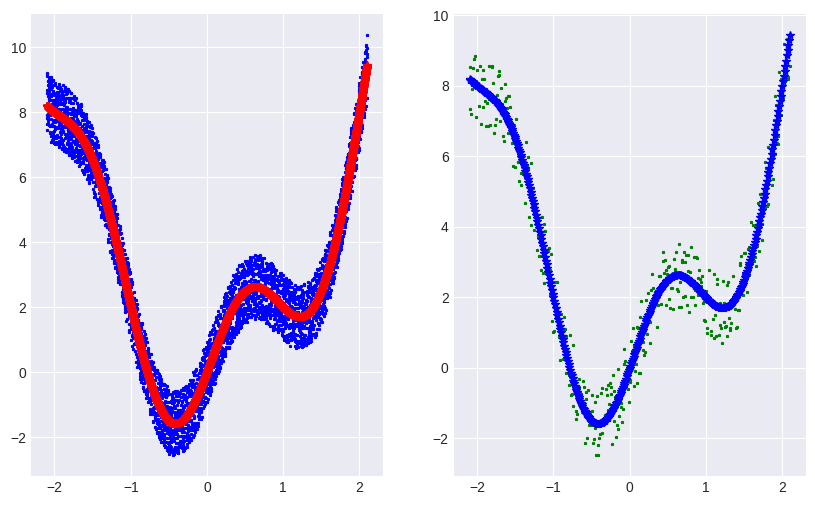

In [51]:
fig, axes = plt.subplots(1,2)
ax = axes[0]
ax.plot(X_train, y_train, 'b*', markersize = 2, label = 'Train')
ax.plot(X_train, y_true, 'r*', linewidth = 2, label = 'True')

ax = axes[1]
ax.plot(X_test, y_test, 'g*', markersize = 2, label = 'Test')
ax.plot(X_test, y_true_test, 'b*', linewidth = 2, label = 'True')

In [42]:
inputs = tf.keras.Input(shape = (1,), name = "input")

x = tf.keras.layers.Dense(128,
                          activation = tf.keras.activations.relu,
                          name = "fc_1")(inputs)

x = tf.keras.layers.Dense(64,
                          activation = tf.keras.activations.relu,
                          name = "fc_2")(x)

outputs = tf.keras.layers.Dense(1, name = "fc_3")(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 1)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 128)                 │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_3 (Dense)                         │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,577 (33.50 KB)

 Trainable params: 8,577 (33.50 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

In [44]:
model.compile(optimizer = "adam",
              loss = 'mean_squared_error',
              metrics = ["mae"])

In [45]:
history = model.fit(X_train, y_train,
                    validation_data = [X_test, y_test],
                    batch_size = BATCH_SIZE,
                    verbose = 2,
                    epochs = EPOCHS)

Epoch 1/50
66/66 - 1s - 19ms/step - loss: 7.7151 - mae: 2.1419 - val_loss: 3.7540 - val_mae: 1.6235
Epoch 2/50
66/66 - 0s - 2ms/step - loss: 3.2050 - mae: 1.4677 - val_loss: 2.5851 - val_mae: 1.3270
Epoch 3/50
66/66 - 0s - 2ms/step - loss: 2.1221 - mae: 1.1838 - val_loss: 1.7013 - val_mae: 1.0642
Epoch 4/50
66/66 - 0s - 3ms/step - loss: 1.4787 - mae: 0.9694 - val_loss: 1.3368 - val_mae: 0.9167
Epoch 5/50
66/66 - 0s - 4ms/step - loss: 1.2521 - mae: 0.8675 - val_loss: 1.2407 - val_mae: 0.8748
Epoch 6/50
66/66 - 0s - 4ms/step - loss: 1.1766 - mae: 0.8366 - val_loss: 1.1867 - val_mae: 0.8584
Epoch 7/50
66/66 - 0s - 2ms/step - loss: 1.1200 - mae: 0.8187 - val_loss: 1.1198 - val_mae: 0.8386
Epoch 8/50
66/66 - 0s - 2ms/step - loss: 1.0496 - mae: 0.7968 - val_loss: 1.0403 - val_mae: 0.8145
Epoch 9/50
66/66 - 0s - 4ms/step - loss: 0.9679 - mae: 0.7703 - val_loss: 0.9489 - val_mae: 0.7843
Epoch 10/50
66/66 - 0s - 2ms/step - loss: 0.8779 - mae: 0.7392 - val_loss: 0.8549 - val_mae: 0.7504
Epoch 11

In [52]:
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

,loss,mae,val_loss,val_mae
0,7.715061,2.141931,3.754022,1.623489
1,3.204952,1.467681,2.585116,1.326975
2,2.122102,1.183807,1.701262,1.064244
3,1.478697,0.969411,1.336848,0.916663
4,1.252127,0.867532,1.240735,0.874763


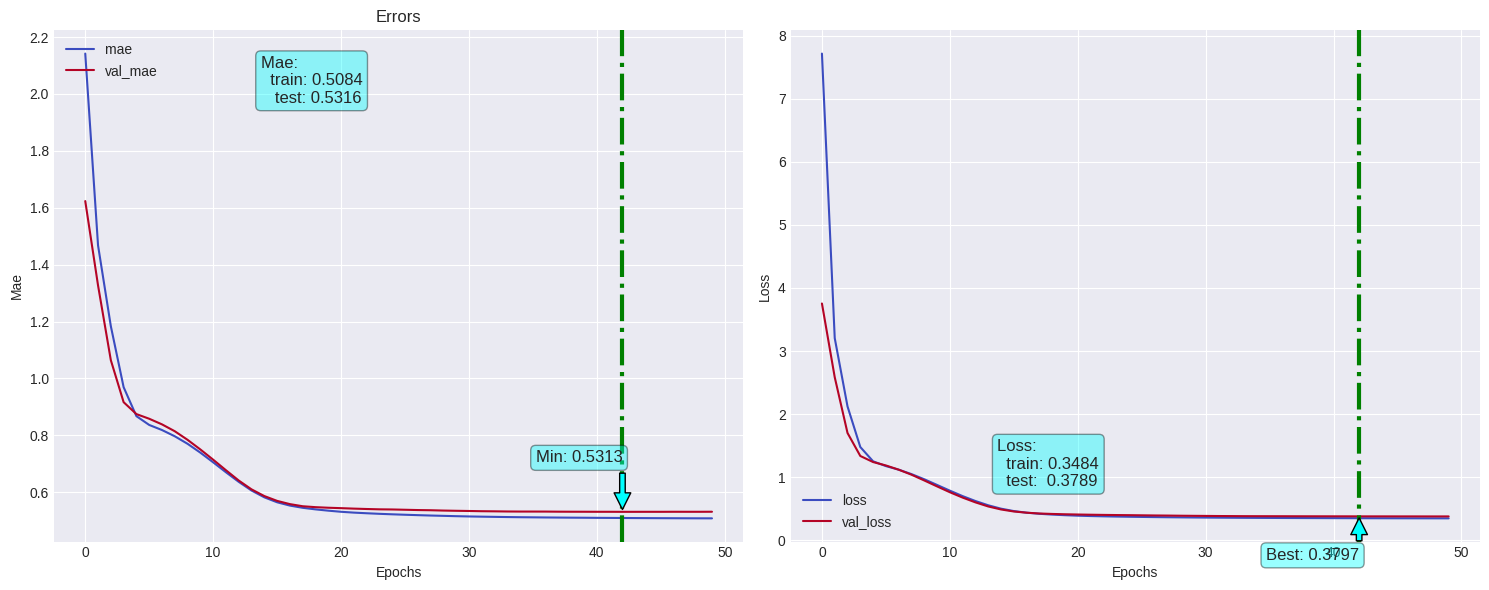

In [53]:
fn_plot_tf_hist(hist_df = hist_df)

In [47]:
error = model.evaluate(X_test, y_test, verbose = 1)

print(f'Loss: {error[0]:.4f} MAE: {error[1]:.4f}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3964 - mae: 0.5387 
Loss: 0.3789 MAE: 0.5316


In [48]:
y_pred = model.predict(X_test)
result_df = pd.DataFrame({'pred' : y_pred[:,0], 'test' : y_test})
result_df['True'] = y_true_test
result_df.head()

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,pred,test,True
0,8.416234,8.539487,8.201966
1,8.381500,7.328536,8.178218
2,8.346766,7.193551,8.155420
3,8.312034,7.915680,8.133514
4,8.277299,8.124319,8.112437


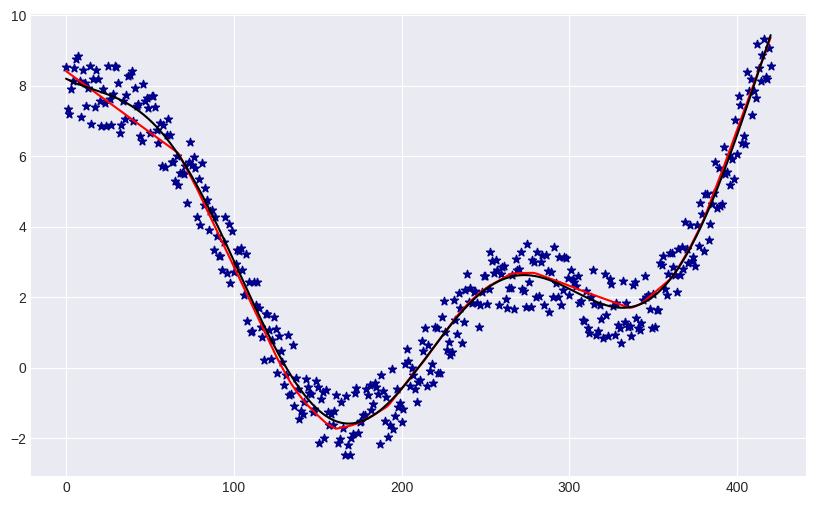

In [50]:
ax = result_df.pred.plot(c = 'r', label = 'pred')
result_df['True'].plot(c = 'k', ax=ax, label = 'True')

plt.scatter(result_df.index, result_df.test, c = 'DarkBlue', marker = '*')